In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
# Define data directories
train_dir = "../data/train1"
validation_dir = "../data/validation"
test_dir = "../data/test"

# Image dimensions and other parameters
img_width, img_height = 48,48
batch_size = 64

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

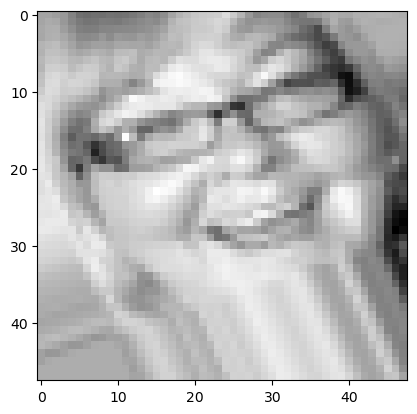

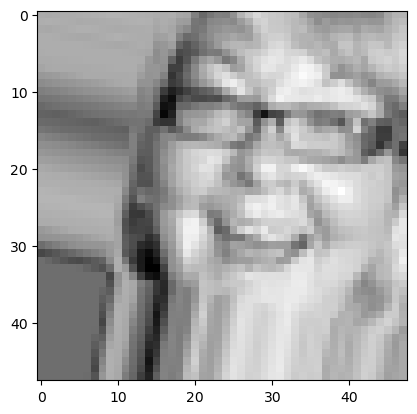

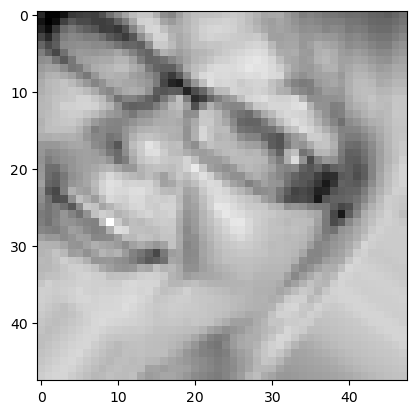

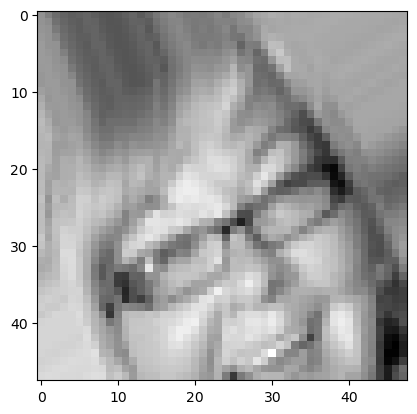

In [3]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

train_happy_dir = os.path.join(train_dir, 'happy')

fnames = [os.path.join(train_happy_dir, fname) for fname in os.listdir(train_happy_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_width, img_height))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [4]:
# Generate batches of image data (train and validation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Del notebook "SEarchCNNStructure" pudimos encontrar que la estructura de CNN óptima era la del Trial 63. A continuación se muestran los parámetros de la estructura óptima encontrada:

Trial 063 summary

Hyperparameters:

conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 5
conv_filters_2: 64
conv_kernel_2: 3
num_dense_layers: 3
dense_units_1: 128
dense_units_2: 96
dense_units_3: 96
dense_units_4: 96
conv_filters_3: 64
conv_kernel_3: 5
conv_filters_4: 128
conv_kernel_4: 3
conv_filters_5: 96
conv_kernel_5: 3
conv_filters_6: 64
conv_kernel_6: 3
conv_filters_7: 64
conv_kernel_7: 5
Score: 0.5798272490501404

## CNN From scratch 

In [5]:
# Define the CNN model
# Vamos a tener: 6 capas convolucionales (intercaladas con capas MaxPooling) y 4 capas densas (la última con units = nºclases de los datos --> 7)

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_width, img_height, 3), padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(64, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

# Flatten layer
model.add(layers.Flatten())

#Añadimos dropout
model.add(layers.Dropout(0.5))

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(96, activation='relu'))
model.add(layers.Dense(96, activation='relu'))

# Output layer
model.add(layers.Dense(7, activation='softmax'))  # 7 output classes (emotions)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 64)       0

In [7]:
# Compile the model
from keras import callbacks
num_epochs = 200
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        patience=10,
                                        restore_best_weights=True)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[earlystopping]
)

model.save('model_DataAug.h5')


Epoch 1/200
448/448 [==============================] - 76s 163ms/step - loss: 1.8175 - accuracy: 0.2481 - val_loss: 1.8083 - val_accuracy: 0.2475
Epoch 2/200
448/448 [==============================] - 72s 161ms/step - loss: 1.7985 - accuracy: 0.2520 - val_loss: 1.7919 - val_accuracy: 0.2475
Epoch 3/200
448/448 [==============================] - 73s 162ms/step - loss: 1.7910 - accuracy: 0.2531 - val_loss: 1.7843 - val_accuracy: 0.2540
Epoch 4/200
448/448 [==============================] - 72s 162ms/step - loss: 1.7735 - accuracy: 0.2630 - val_loss: 1.7011 - val_accuracy: 0.3037
Epoch 5/200
448/448 [==============================] - 73s 162ms/step - loss: 1.7082 - accuracy: 0.2987 - val_loss: 1.5983 - val_accuracy: 0.3322
Epoch 6/200
448/448 [==============================] - 73s 162ms/step - loss: 1.6153 - accuracy: 0.3515 - val_loss: 1.4862 - val_accuracy: 0.4206
Epoch 7/200
448/448 [==============================] - 72s 161ms/step - loss: 1.5399 - accuracy: 0.3956 - val_loss: 1.4326 -

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

In [8]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.817515,0.248071,1.808277,0.247489
1,1.798470,0.251981,1.791918,0.247489
2,1.791021,0.253133,1.784314,0.254046
3,1.773518,0.263048,1.701075,0.303711
4,1.708164,0.298691,1.598254,0.332171


<Axes: title={'center': 'Losses'}, xlabel='Epochs', ylabel='Loss'>

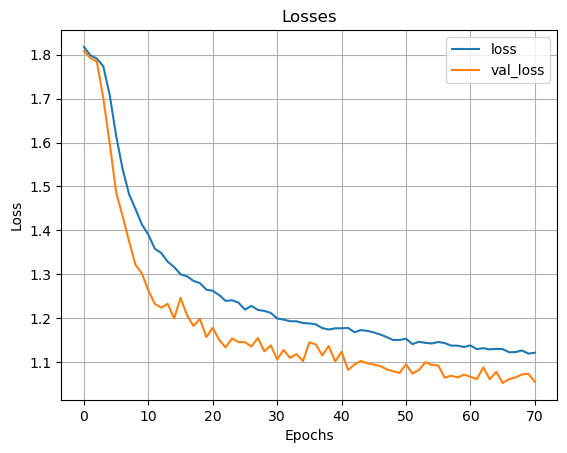

In [9]:
df_history['loss'].plot(legend=True)
df_history['val_loss'].plot(title='Losses', grid=True,
                              xlabel='Epochs',
                              ylabel='Loss',
                              legend=True)

<Axes: title={'center': 'Accuracies'}, xlabel='Epochs', ylabel='Accuracy'>

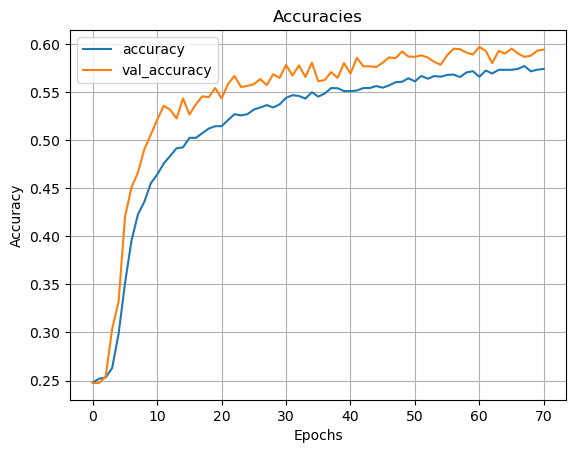

In [10]:
df_history['accuracy'].plot(legend=True)
df_history['val_accuracy'].plot(title='Accuracies', grid=True,
                              xlabel='Epochs',
                              ylabel='Accuracy',
                              legend=True)